In [4]:
# !pip install numpy
# !pip install matplotlib
# Basic setup: imports and define helper functions
import asyncio, asyncssh, sys, time
import numpy as np
import matplotlib.pyplot as plt

ssh_connections = {}
%store -r

async def start_connection(hostname):
    if hostname not in ssh_connections:
        ssh_connections[hostname] = await asyncssh.connect(hostname, known_hosts=None)
    return ssh_connections[hostname]

async def run_command(hostname, command):
    conn = await start_connection(hostname)
    return (await conn.create_process(command))

async def run_command_sync(hostname, command):
    conn = await start_connection(hostname)
    result = await conn.run(command)
    return result.stdout

async def run_server(hostname):
    return (await run_command(hostname, '/mydata/localuser/frida/server/server'))

async def run_client_throughput(hostname, device_id, duration = 10, keepout = 1, datasize = 32, server="http://node0:8080", asyncOn = True):
    command_str = '/mydata/localuser/frida/experiments/throughput_bench/client {} {} {} {} {}'.format(device_id, duration,keepout,datasize,server)
    if asyncOn:
        return (await run_command(hostname, command_str))
    else:
        return (await run_command_sync(hostname, command_str))
async def run_multiple_clients_throughput(num_clients, hostname, device_id_prefix, duration = 10, keepout = 1, datasize = 32, server="http://node0:8080", asyncOn = True):
    command_str = 'cd /mydata/localuser/frida/experiments/throughput_bench && bash ./run_clients_local.sh {} {} {} {} {} {}'.format(num_clients, device_id_prefix, duration,keepout,datasize,server)
    if asyncOn:
        return (await run_command(hostname, command_str))
    else:
        return (await run_command_sync(hostname, command_str))

async def run_multiple_clients_latency(num_clients, hostname, device_id_prefix, duration = 10, keepout = 1, datasize = 32, server="http://node0:8080", throughput = 80, asyncOn = True):
    command_str = 'cd /mydata/localuser/frida/experiments/latency_bench && bash ./run_clients_local.sh {} {} {} {} {} {} {}'.format(num_clients, device_id_prefix, duration,keepout,datasize,server, throughput)
    if asyncOn:
        return (await run_command(hostname, command_str))
    else:
        return (await run_command_sync(hostname, command_str))
    
async def clear_server_storage(hostname):
    await run_command_sync(hostname, "rm -r ~/storage")

async def kill_server(hostname):
    await run_command_sync(hostname, "pkill server")
    
def parse_throughput(tstr):
    return float(tstr.split(",")[1])

def parse_latency(tstr):
    res = tstr.split(",")
#     print(res)
    return float(res[1]), float(res[2]), float(res[3])

# Kill everything
async def cleanup(num_nodes):
    for i in range(1, num_nodes + 1):
        await run_command_sync("node{}".format(i), "pkill client")
    await kill_server("node0")
    await clear_server_storage("node0")




In [24]:
cstr= 'cd /mydata/localuser/frida/experiments/throughput_bench && bash ./run_clients_local.sh {} {} {} {} {} http://node0:8080'.format(100, "LEO", 20,5,32)
await run_command("node2", cstr)

In [56]:
await cleanup(10)

In [46]:
await kill_server("node0")
await clear_server_storage("node0")
server_task = await run_server("node0")

In [54]:
async def run_throughput_exp(num_nodes = 2, duration = 20, keepout = 5, data_size = 0, min_cpn = 20, max_cpn = 100, step_size = 5, warmup_period = 5, server_node = "node0"):
    max_clients = max_cpn * num_nodes
    throughputs = [0]
    num_clients_record = [0]
    

    for num_clients_per_node in range(min_cpn, max_cpn + 1, step_size):
        await cleanup(num_nodes)
        time.sleep(10)
        server_task = await run_server(server_node)
        time.sleep(warmup_period)
        ctasks = []
        num_clients = num_nodes * num_clients_per_node
        for node in range(1, num_nodes + 1):
            ctask = await run_multiple_clients_throughput(num_clients_per_node, "node{}".format(node), "exp_C{}_node{}".format(num_clients, node), duration, keepout, data_size, "http://node0:8080")
            ctasks.append(ctask)
        local_throughputs = []
        time.sleep(duration + warmup_period)
        for ctask in ctasks:
            coutput = await ctask.stdout.read()
            for line in coutput.split("\n")[:-1]:
                if line != "":
                    local_throughputs.append(parse_throughput(line))
            ctask.terminate()
        num_clients_record.append(num_clients)

        throughput = sum(local_throughputs)
        print("#Nodes={}, #Clients={}, Throughput = {}/s".format(num_nodes, num_clients, throughput))
        throughputs.append(throughput)

    server_task.terminate()
    await clear_server_storage(server_node)
    return num_clients_record, throughputs

In [50]:
async def run_latency_exp(num_nodes = 10, duration = 20, keepout = 5, data_size = 0, num_clients_per_node = 20, min_tpc = 5, max_tpc = 80, step_size=5, warmup_period = 5, server_node = "node0"):
    throughputs = []
    latencies = []
    num_clients_record = [0]
    
    for throughput in range(min_tpc, max_tpc + 1, step_size):
        await cleanup(num_nodes)
        time.sleep(10)
        server_task = await run_server(server_node)
        time.sleep(warmup_period)
        ctasks = []
        num_clients = num_nodes * num_clients_per_node
        for node in range(1, num_nodes + 1):
            ctask = await run_multiple_clients_latency(num_clients_per_node, "node{}".format(node), "exp_C{}_node{}".format(num_clients, node), duration, keepout, data_size, "http://node0:8080", throughput)
            ctasks.append(ctask)
        local_throughputs = []
        local_latencies = []
        local_nmsg = []
        time.sleep(duration + warmup_period)
        for ctask in ctasks:
            coutput = await ctask.stdout.read()
            for line in coutput.split("\n")[:-1]:
                if line != "":
                    thrput, lat, nmsg = parse_latency(line)
                    local_throughputs.append(thrput)
                    local_latencies.append(lat)
                    local_nmsg.append(nmsg)
            ctask.terminate()
#         num_clients_record.append(num_clients)

        throughput = sum(local_throughputs)
        sum_lat = 0.0
        for i in range(len(local_latencies)):
            sum_lat += local_latencies[i] * local_nmsg[i]
        num_msgs = sum(local_nmsg)
        avg_lat = sum_lat / num_msgs
        print("#Nodes={}, #Clients={}, Throughput = {}, Latency = {}ms, #Received = {}".format(num_nodes, num_clients, throughput, avg_lat, num_msgs))
        throughputs.append(throughput)
        latencies.append(avg_lat)

    server_task.terminate()
    await clear_server_storage(server_node)
    return throughputs, latencies

In [39]:
throughputs_N10C20, latencies_N10C20 = await run_latency_exp(num_nodes=10, duration = 30, keepout = 5, num_clients_per_node=20, min_tpc = 20, max_tpc = 150, step_size = 10,warmup_period = 3)
%store throughputs_N10C20
%store latencies_N10C20

#Nodes=10, #Clients=200, Throughput = 4000.0, Latency = 9.443216324999996ms, #Received = 80000.0
#Nodes=10, #Clients=200, Throughput = 5987.350000000004, Latency = 8.115980021537114ms, #Received = 119705.0
#Nodes=10, #Clients=200, Throughput = 7940.8499999999985, Latency = 7.612311629530287ms, #Received = 158820.0
#Nodes=10, #Clients=200, Throughput = 9872.149999999987, Latency = 7.414702768339033ms, #Received = 197445.0
#Nodes=10, #Clients=200, Throughput = 11845.699999999999, Latency = 7.436674512515411ms, #Received = 236844.0
#Nodes=10, #Clients=200, Throughput = 13675.099999999999, Latency = 7.947576716850788ms, #Received = 273459.0
#Nodes=10, #Clients=200, Throughput = 15383.549999999994, Latency = 8.848720324208983ms, #Received = 307675.0
#Nodes=10, #Clients=200, Throughput = 16354.100000000004, Latency = 10.254407451354135ms, #Received = 326852.0
#Nodes=10, #Clients=200, Throughput = 16933.000000000007, Latency = 10.980319437351907ms, #Received = 338454.0
#Nodes=10, #Clients=200

In [44]:
throughputs_N4C20, latencies_N4C20 = await run_latency_exp(num_nodes=4, duration = 30, keepout = 5, num_clients_per_node=20, min_tpc = 50, max_tpc = 300, step_size = 10,warmup_period = 3)
%store throughputs_N4C20
%store latencies_N4C20

#Nodes=4, #Clients=80, Throughput = 3966.5999999999995, Latency = 9.558690287282719ms, #Received = 79333.0
#Nodes=4, #Clients=80, Throughput = 4725.100000000001, Latency = 8.627670114202855ms, #Received = 94481.0
#Nodes=4, #Clients=80, Throughput = 5495.350000000002, Latency = 7.948645530324595ms, #Received = 109891.0
#Nodes=4, #Clients=80, Throughput = 6190.05, Latency = 8.174614599531514ms, #Received = 123803.0
#Nodes=4, #Clients=80, Throughput = 6407.700000000001, Latency = 8.767244728081605ms, #Received = 128123.0
#Nodes=4, #Clients=80, Throughput = 6990.300000000001, Latency = 8.08656356568318ms, #Received = 139809.0
#Nodes=4, #Clients=80, Throughput = 7342.0, Latency = 8.17098292840021ms, #Received = 146763.0
#Nodes=4, #Clients=80, Throughput = 7593.599999999998, Latency = 8.423305445201827ms, #Received = 151766.0
#Nodes=4, #Clients=80, Throughput = 8095.900000000001, Latency = 8.085755256952588ms, #Received = 161803.0
#Nodes=4, #Clients=80, Throughput = 8884.700000000003, Latenc

CancelledError: 

In [37]:
def co_sort(arr1, arr2, on="first"):
    combined = [(arr1[i], arr2[i]) for i in range(len(arr1))]
    combined.sort(key=(lambda x:x[0]) if on=="first" else (lambda x:x[1]))
    return [e[0] for e in combined],[e[1] for e in combined]

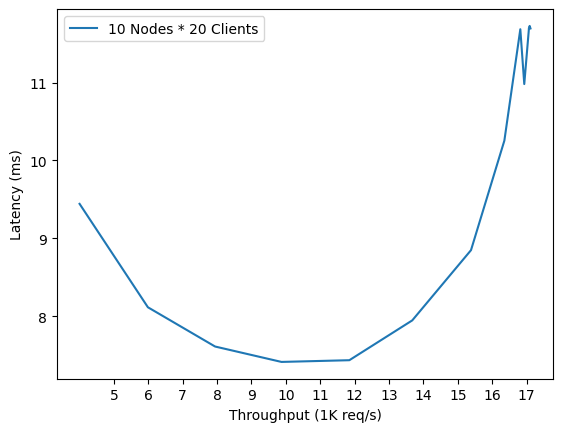

In [40]:
throughputs_sorted, latencies_sorted = co_sort(throughputs_N10C20, latencies_N10C20)
plt.plot(np.array(throughputs_sorted)/1000, latencies_sorted, label="10 Nodes * 20 Clients")
# plt.plot(num_clients, throughputs, label="22")
plt.xticks(np.arange(5, 18, step = 1))
plt.xlabel("Throughput (1K req/s)")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()

In [55]:
num_clients_n1, throughputs_n1 = await run_throughput_exp(num_nodes = 1, min_cpn = 8, max_cpn = 200, step_size=8)
%store num_clients_n1
%store throughputs_n1

num_clients_n2, throughputs_n2 = await run_throughput_exp(num_nodes = 2, min_cpn = 4, max_cpn = 100, step_size=4)
%store num_clients_n2
%store throughputs_n2

num_clients_n4, throughputs_n4 = await run_throughput_exp(num_nodes = 4, min_cpn = 2, max_cpn = 50, step_size=2)
%store num_clients_n4
%store throughputs_n4

num_clients_n8, throughputs_n8 = await run_throughput_exp(num_nodes = 8, min_cpn = 1, max_cpn = 25, step_size=1)
%store num_clients_n8
%store throughputs_n8

#Nodes=1, #Clients=8, Throughput = 632.4000000000001/s
#Nodes=1, #Clients=16, Throughput = 1263.0/s
#Nodes=1, #Clients=24, Throughput = 1869.0/s
#Nodes=1, #Clients=32, Throughput = 2502.3999999999996/s
#Nodes=1, #Clients=40, Throughput = 2706.9000000000005/s
#Nodes=1, #Clients=48, Throughput = 3598.5/s


CancelledError: 

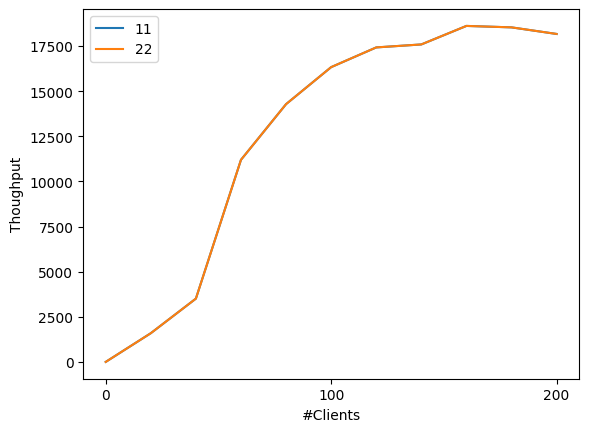

In [60]:
plt.plot(num_clients, throughputs, label="11")
plt.plot(num_clients, throughputs, label="22")
plt.xticks(np.arange(0,max_clients + 1, step = step_size * num_nodes * 5))
plt.xlabel("#Clients")
plt.ylabel("Thoughput")
plt.legend()
plt.show()

In [28]:
await clear_server_storage("node0")
await kill_server("node0")